In [1]:
'''
Script to visualize and compare job results from 
various backends (simulator, emulator, and real device).
'''

import numpy as np
from qiskit import transpile
from func_qc import qc_backend
import func_matrix_vector as matvec
from qiskit import qpy
import argparse
import pickle
import matplotlib.pyplot as plt

parser = argparse.ArgumentParser()
parser.add_argument("-case", "--case_name",  type=str, default='sample-tridiag', required=False, help="Name of the problem case: 'sample-tridiag', 'hele-shaw'")
parser.add_argument("-casefile", "--case_variable_file",  type=str, default='ideal', required=False, help="YAML file containing variables for the case: 'input_vars.yaml'")

parser.add_argument("-s", "--SHOTS", type=int, default=1000, required=True, help="Numer of shots for the simulator.")
parser.add_argument("--gpu", default=False, action='store_true', help="Use GPU backend for Aer simulator.")
parser.add_argument("--gpumultiple", default=False, action='store_true', help="Use multiple GPUs for the backend of Aer simulator.")
parser.add_argument("-backtyp", "--backend_type",  type=str, default='real-qtuum', required=False, help="Type of the backend: 'ideal', 'fake' 'real-ibm' 'real-qtuum'")
parser.add_argument("-backmet", "--backend_method",  type=str, default='H1-1E', required=False, help="Method/name of the backend. E.g. 'statevector', 'simulator_statevector' 'FakeNairobi' 'ibm_nairobi' 'H1-1E' 'H2-1E' 'H1-1' 'H2-1'")

parser.add_argument("--savedata", default=False, action='store_true', help="Save data at `models/<filename>` with `<filename>` based on parameters.")
parser.add_argument("--loadcirc", default=False, action='store_true', help="Load circuit at `models/<filename>` with `<filename>` based on parameters.")
parser.add_argument("--loadcirctranspile", default=False, action='store_true', help="Load transpiled circuit at `models/<filename>` with `<filename>` based on parameters.")

# Case details
# NOTE: CHANGE these according to your case
args = parser.parse_args(['-s 500'])
args.case_name = 'sample-tridiag'
args.case_variable_file = 'input_vars.yaml'
args.backend_type = 'ideal' 
args.backend_method = 'statevector'

In [2]:
# ### Get system matrix and vector
matrix, vector, input_vars = matvec.get_matrix_vector(args)
backend = qc_backend('ideal', 'statevector', args)

# ### Get circuit
n_qubits_matrix = int(np.log2(matrix.shape[0]))
filename = input_vars['savefilename'].format(**input_vars)
savefilename = f'{filename}_circ_nqmatrix{n_qubits_matrix}'
with open(f'{savefilename}.qpy', 'rb') as fd:
    circ = qpy.load(fd)[0]
circ.measure_all()
circ = transpile(circ, backend)

Case: Sample tridiagonal


In [3]:
# Define backends to be compared
providers = ["ibm", "iqm"]  # Provider name. Repeat for multiple backends from same provider
machines = ["fake_sherbrooke", "garnet:mock"] # backend/machine correponding to each provider
# define some unique colors and line styles
color_list = ['tab:red', 'tab:green', 'tab:blue', 'tab:cyan', 'tab:grey', 'tab:orange']
line_styles = ['--', '-.', '-.', ':', '-']
widths = [0.8, 0.65, 0.5, 0.35, 0.2]
legend_list = []
counts = []
cases = len(machines) + 1

plot_probabilities = True
figfilename = f'Figs/sample-HHL_compare-results'
saveFig = False

In [4]:
def get_results(provider, machine):
    # Load counts for a given backend method
    fname = f'{filename}_circ-fullresults_nqmatrix{n_qubits_matrix}_backend-{machine}_shots{args.SHOTS}.pkl'
    print(fname)
    if provider in ["ibm", "iqm"]:
        with open(fname, 'rb') as file:
            counts_device = pickle.load(file)['counts']
    counts_device = sorted(counts_device.items(), key=lambda x: str(x[0])) # sort counts based on bit registers
    return counts_device

In [5]:
# Collect counts from all backend methods
i = 0
for provider in providers:
    machine = machines[i]
    print(f"{provider}: {machine}")
    counts_device = get_results(provider, machine)
    if plot_probabilities: counts_device = [(key, value / args.SHOTS) for key, value in counts_device] # normalize for quasi-probability
    counts += [counts_device,]
    legend_list += [machine,]
    i += 1

ibm: fake_sherbrooke
models/sample_HHL_circ-fullresults_nqmatrix1_backend-fake_sherbrooke_shots500.pkl
iqm: garnet:mock
models/sample_HHL_circ-fullresults_nqmatrix1_backend-garnet:mock_shots500.pkl


In [6]:
# Run circuit on simulator to compare results
counts_aer = backend.run(circ, shots=args.SHOTS).result().get_counts()
counts_aer = sorted(counts_aer.items(), key=lambda x: str(x[0])) # sort counts based on bit registers
if plot_probabilities: counts_aer = [(key, value / args.SHOTS) for key, value in counts_aer] # normalize for quasi-probability
counts += [counts_aer,]
legend_list += ["aer sim",]

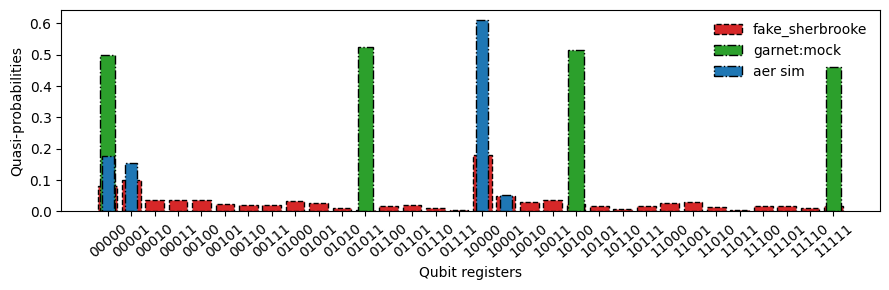

In [7]:
# Plot results
transparency = 1

fig, ax = plt.subplots(figsize=(9, 3))
for i, dataset in enumerate(counts):
    x = [str(item[0]) for item in dataset]
    y = [item[1] for item in dataset]
    bars = ax.bar(x, y, color=color_list[i], alpha=transparency, width=widths[i], label=legend_list[i], edgecolor='k')
    # Set edge style for each bar
    for bar in bars:
        bar.set_linestyle(line_styles[i])

ax.legend(loc='best', frameon=False);
ax.set_xlabel('Qubit registers')  # Bitstring
if plot_probabilities: ax.set_ylabel('Quasi-probabilities')
else: ax.set_ylabel('Counts')
# Extract unique keys while preserving order
unique_keys = []
for dataset in counts:
    for item in dataset:
        key = item[0]
        if key not in unique_keys:
            unique_keys.append(key)

ax.set_xticks(range(len(unique_keys)))  # Set ticks positions
ax.set_xticklabels(unique_keys, rotation=40)  # Set unique keys as labels

fig.tight_layout()

if saveFig: plt.savefig(f"{figfilename}_dist.png", dpi=200)